In [53]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from bilby.gw.conversion import total_mass_and_mass_ratio_to_component_masses, bilby_to_lalsimulation_spins as spin_convert
from pesummary.gw.conversions.spins import opening_angle
from pesummary.gw.conversions.angles import _dpsi, _dphi
from calcwf import *

In [28]:
hp, hc = gen_prec_wf_fd(10, 60, 2, 0, 0, 0, 0, np.pi/2, np.pi/2, np.pi/2, 0.7, 1)

In [31]:
hp[123123]*1j

(-1.0550700059555993e-22+1.0035323666447363e-22j)

In [32]:
hc[123123]

(1.0728614527832333e-22-1.0176707960353981e-22j)

In [91]:
# Generate a precessing waveform in frequency domain
def gen_prec_wf_fd(f_low, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, approximant='IMRPhenomXP', sample_rate=4096, delta_f=1/256, apply_detector_response=True):

    # Convert parameters
    mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = spin_convert(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, mass_1, mass_2, f_low, phase)

    # Generate waveform
    hp, hc = get_fd_waveform(approximant=approximant, 
                             mass1=mass_1,
                             mass2=mass_2,
                             f_lower=f_low,
                             f_final=sample_rate/2,
                             delta_f=delta_f,
                             inclination=iota,
                             spin1x=spin_1x,
                             spin1y=spin_1y,
                             spin1z=spin_1z,
                             spin2x=spin_2x,
                             spin2y=spin_2y,
                             spin2z=spin_2z,
                             coa_phase=phase)

    # Apply effective detector response
    if apply_detector_response:
        beta = opening_angle(mass_1, mass_2, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, f_low, phase)
        dpsi = _dpsi(theta_jn, phi_jl, beta)
        fp = np.cos(2 * (psi - dpsi))
        fc = -1. * np.sin(2 * (psi - dpsi))
        h = (fp * hp + fc * hc)
        h *= np.exp(2j * _dphi(theta_jn, phi_jl, beta))
    else:
        h = hp

    return h

# Generate a precessing waveform in time domain from frequency domain
def gen_prec_wf_td_from_fd(f_low, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, approximant='IMRPhenomXP', sample_rate=4096, delta_f=1/256, apply_detector_response=True):

    # Generate in frequency domain
    h_fd = gen_prec_wf_fd(f_low, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, 
                          approximant=approximant, sample_rate=sample_rate, delta_f=delta_f, apply_detector_response=apply_detector_response)

    # Convert to (complex) time domain
    h0 = h_fd.to_timeseries()
    h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=h0.sample_times[0], dtype=np.complex128)
    hpi2 = (1j*h_fd).to_timeseries()
    hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=hpi2.sample_times[0], dtype=np.complex128)
    h = h0+1j*hpi2

    return h0+1j*hpi2

# Generate a precessing waveform in time domain
def gen_prec_wf_td(f_low, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, approximant='IMRPhenomXP', sample_rate=4096):

    # Convert parameters
    mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = spin_convert(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, mass_1, mass_2, f_low, phase)

    # Generate waveform
    hp, hc = get_td_waveform(approximant=approximant, 
                             mass1=mass_1,
                             mass2=mass_2,
                             f_lower=f_low,
                             delta_t=1/sample_rate,
                             inclination=iota,
                             spin1x=spin_1x,
                             spin1y=spin_1y,
                             spin1z=spin_1z,
                             spin2x=spin_2x,
                             spin2y=spin_2y,
                             spin2z=spin_2z,
                             coa_phase=phase)
    
    return hp - 1j*hc

In [150]:
def gen_prec_wf(f_low, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, approximant='IMRPhenomXP', sample_rate=4096, apply_detector_response=True):

    # Convert parameters
    mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = spin_convert(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, mass_1, mass_2, f_low, phase)

    # Generate waveform
    hp, hc = get_td_waveform(approximant=approximant, 
                             mass1=mass_1,
                             mass2=mass_2,
                             f_lower=f_low,
                             delta_t=1/sample_rate,
                             inclination=iota,
                             spin1x=spin_1x,
                             spin1y=spin_1y,
                             spin1z=spin_1z,
                             spin2x=spin_2x,
                             spin2y=spin_2y,
                             spin2z=spin_2z,
                             coa_phase=phase)

    # Apply effective detector response if requested
    if apply_detector_response:
        beta = opening_angle(mass_1, mass_2, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, f_low, phase)
        dpsi = _dpsi(theta_jn, phi_jl, beta)
        dphi = _dphi(theta_jn, phi_jl, beta)
        fp = np.cos(2 * (psi - dpsi))
        fc = -1. * np.sin(2 * (psi - dpsi))
        hr = (fp * hp + fc * hc)
        hi = (fp * hc - fc * hp)
        h = hr - 1j*hi
        h *= np.exp(-2j * dphi)
    else:
        h = hp - 1j*hc

    return h

In [159]:
# Make precessing harmonics
def gen_prec_harms(f_low, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, harmonics=[0,1,2,3,4], approximant='IMRPhenomXP', sample_rate=4096):

    # Generate constituent waveforms
    if 0 in harmonics or 4 in harmonics:
        x_0_0_0_0 = gen_prec_wf(f_low, M, q, 0, 0, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate)
        x_0_0_pi4_pi4 = gen_prec_wf(f_low, M, q, 0, 0, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate)
    if 1 in harmonics or 3 in harmonics:
        x_pi2_0_pi4_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, 0, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate)
        x_pi2_pi2_0_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, 0, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate)
    if 2 in harmonics:
        x_pi2_0_0_0 = gen_prec_wf(f_low, M, q, np.pi/2, 0, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate)
        x_pi2_pi2_0_0 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate)

    # Above uses six waveforms - can this be simplified to five?

    # Combine to make _0 harmonics
    harms = []
    if 0 in harmonics:
        harms.append((1/2)*(x_0_0_0_0-x_0_0_pi4_pi4))
    if 1 in harmonics or 3 in harmonics:
        harms.append(-(1/4)*(x_pi2_0_pi4_pi4+x_pi2_pi2_0_pi4))
    if 2 in harmonics:
        harms.append((1/6)*(x_pi2_0_0_0+x_pi2_pi2_0_0))
    if 3 in harmonics:
        harms.append(-(1/4)*(x_pi2_0_pi4_pi4-x_pi2_pi2_0_pi4))
    if 4 in harmonics:
        harms.append((1/2)*(x_0_0_0_0+x_0_0_pi4_pi4))

    return harms

In [206]:
# Get harmonics
harms = gen_prec_harms_fd(20, 30, 2, np.pi/2, np.pi/2, np.pi/2, 0.7, 0)

# Compute orthogonality
for i in range(len(harms)):
    for j in range(i+1):
        print(i, j, np.abs(overlap_cplx_wfs(harms[i], harms[j], 20, f_match=20, normalized=True)))
    print('\n')

0 0 1.0


1 0 0.20999436518830605
1 1 1.0


2 0 0.03431966921998534
2 1 0.36254676902322774
2 2 1.0


3 0 0.9941975714558264
3 1 0.24302752480734635
3 2 0.027762727863031987
3 3 1.0


4 0 0.09546530802830036
4 1 0.18071545482217916
4 2 0.6780177803978659
4 3 0.0480708446485833
4 4 1.0




In [50]:
from pesummary.gw.conversions.snr import _calculate_precessing_harmonics, _make_waveform
from pesummary.gw.conversions.spins import opening_angle
from pycbc.filter import match
from pycbc.types import timeseries

(253.0, 253.5)

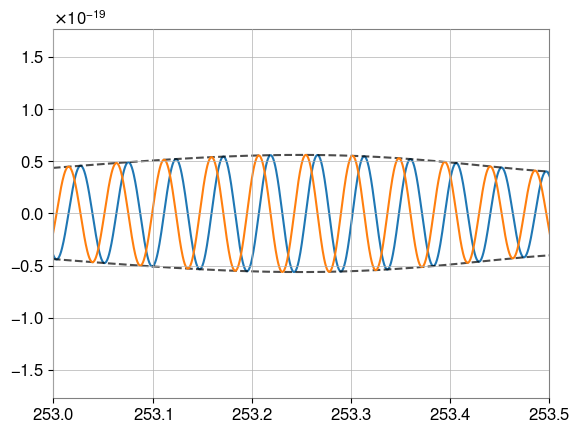

In [21]:
h = _make_waveform("IMRPhenomPv2", 0.76345435, 1.23536234, 2.823454, 3.8345, 20, 10, np.pi/2, np.pi/2, np.pi/2, 0.7, 0, 0, 1, apply_detector_response=True)
h0 = h.to_timeseries()
h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
ih = 1j*h
hpi2 = ih.to_timeseries()
hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
h = h0+1j*hpi2

plt.plot(h.sample_times, h)
plt.plot(h.sample_times, np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.sample_times, -np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.imag().sample_times, h.imag())
plt.xlim(253,253.5)

In [204]:
# Get harmonics
beta = opening_angle(20, 10, 0, np.pi/2, np.pi/2, np.pi/2, 0.7, 0, 20, 0)
harms = _calculate_precessing_harmonics(20, 10, 0.7, 0,  np.pi/2, np.pi/2, np.pi/2, beta, 1, harmonics=[0,1,2,3,4])
psd = aLIGOZeroDetHighPower(len(harms[0]), harms[0].delta_f, 20)

# Check orthogonality
for i in range(len(harms)):
    for j in range(i+1):
        print(i, j, np.abs(overlap_cplx(harms[i], harms[j], psd=psd, low_frequency_cutoff=20)))
    print('\n')

0 0 1.0


1 0 0.0571311216188576
1 1 1.0


2 0 0.05551949144119885
2 1 0.09051091723001596
2 2 0.9999999999999998


3 0 0.046611443919037626
3 1 0.07422390393078732
3 2 0.13502421077147356
3 3 0.9999999999999999


4 0 0.03898836595773121
4 1 0.06046892000503533
4 2 0.09658590766139541
4 3 0.18822269760773988
4 4 1.0


